## Simple grouping

Group generalized data

In [219]:
import os, json
from collections import Counter

In [220]:
# patterns_folder = os.path.join("spider_data", "patterns_dev_no_synonyms_values_first")

patterns_folder = os.path.join("spider_data", "patterns_no_synonyms_values_first")
# patterns_folder = os.path.join("spider_data", "patterns")

entries = []

for pattern_json_file_name in os.listdir(patterns_folder):
    if pattern_json_file_name.endswith(".json"):
        pattern_json_file = os.path.join(patterns_folder, pattern_json_file_name)
        with open(pattern_json_file, "r") as json_file:
            entries.extend(entry for entry in json.load(json_file))

print(f"Loaded {len(entries)} entries")

Loaded 6642 entries


In [221]:
entries_string = [" ".join(entry["generalized_tokens"]).lower() for entry in entries]

In [222]:
exact_counter = Counter(entries_string)

In [223]:
entries.sort(key=lambda x: x["generalized_nl"])

with open(os.path.join(patterns_folder, "all.csv"), "w") as all_csv:
    for entry in entries:
        all_csv.write(f'{" ".join(entry["generalized_tokens"]).lower()};{entry["id"]};{entry["original_nl"]};{entry["original_sql"]}\n')



In [224]:
match_count = 0

for s, c in exact_counter.most_common():
    if c == 1:
        break
    print(f"{c}: {s}")
    match_count += 1

print(f"Found {len(exact_counter)} different entries (with {match_count} grouped entries)")

63: how many {table} are there
27: count the number of {table}
21: how many {table} do we have
11: count the {column_part} of {table}
11: what are the {column} and {column} of {table}
10: how many {column} are there
8: how many {table} are there in total
7: list the {column} of {table} in ascending order of {column}
7: show all {column}
6: what are the {column} and {column} of all {table}
6: list the {column} of {table} whose {column} is not {value}
6: what are the {column} of {table}
6: how many distinct {column} are there
5: which {column} has the most {table}
5: please show the most common {column} of {table}
5: show the {column} that have {number} {table}
5: what are the {column} of {table} whose {column} is not {value}
5: which {column} have {number} {table}
5: what are the different {column}
4: what is the {column_part} of the {table} named {ne}
4: count the number of different {column}
4: what are the {column} of all the {table}
4: how many {table} are in each {table}
4: how man

In [ ]:
from nltk import FreqDist, ngrams

MAX_SUBSTRING_LENTH = 10
MAX_COMMON = 50

print(len(entries_string))

for i in range(1, MAX_SUBSTRING_LENTH+1):
    fd = FreqDist()
    for entry in entries:
        fd.update(ngrams(entry["generalized_tokens"], i))
    # print(";".join(str(c) for _, c in fd.most_common(MAX_COMMON)))

    covered_counts = []

    for subsent_tokens, _ in fd.most_common(MAX_COMMON):
        subsent = " ".join(subsent_tokens).lower()
        covered_counts.append(sum(1 for query_string in entries_string if subsent in query_string))
    covered_counts.sort(reverse=True)
    print(";".join(str(c) for c in covered_counts))
    # print(";".join(str(sum(1 for query_string in entries_string if " ".join(subsent) in query_string)) for subsent, _ in fd.most_common(MAX_COMMON)))

In [226]:
sentences_set = set(" ".join(entry["generalized_tokens"]) for entry in entries)
sentences_set_list = list(sentences_set)

In [227]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

In [228]:
import numpy as np

In [ ]:
common = []

for i, (tg, count) in enumerate(fd_tri.most_common(5)):
    tg_sent = " ".join(tg)
    print(f"{count}: {tg_sent}")
    containing_sents = [sent for sent in sentences_set if tg_sent in sent]
    containing_sents_embeddings = embedder.encode(containing_sents)
    common.append({
        "trigram": tg,
        "trigram_sent": tg_sent,
        "containing_sents": containing_sents,
        "containing_sents_embeddings": containing_sents_embeddings
    })
    np.savetxt(os.path.join(patterns_folder, f"common{str(i)}.tsv"), containing_sents_embeddings, delimiter="\t")

In [ ]:
all_embeddings = [] #common[0]["containing_sents_embeddings"]
labels = [] # [common[0]["trigram_sent"]] * len(common[0]["containing_sents"])

for c in common:
    all_embeddings.extend(c["containing_sents_embeddings"])
    labels.extend([c["trigram_sent"]] * len(c["containing_sents"]))
    print(c["trigram_sent"])

np.savetxt(os.path.join(patterns_folder, f"common.tsv"), all_embeddings, delimiter="\t")

with open(os.path.join(patterns_folder, "common_labels.txt"), "w") as all_labels:
    all_labels.write("\n".join(labels))
    all_labels.write("\n")

In [ ]:
encoded_file_full_path = os.path.join(patterns_folder, "encoded.npy")

if os.path.isfile(encoded_file_full_path):
    question_embeddings = np.load(encoded_file_full_path)
else:
    question_embeddings = embedder.encode(sentences_set_list)
    np.save(encoded_file_full_path, question_embeddings)

In [229]:
different_sentences = list(exact_counter.keys())
different_sentences_tokens = [s.split(' ') for s in different_sentences]
different_sentences_indices = list(range(len(different_sentences_tokens)))

In [230]:
PLOTS_FOLDER = os.path.join("spider_data", "plots")

In [231]:
SIMILARITY_N = 4

def ngram_overlap(sent1_tokens, sent2_tokens):
    """
    Return the n-gram overlap between two given sentences

    :param sent1_tokens:
    :type sent1_tokens:
    :param sent2_tokens:
    :type sent2_tokens:
    :return:
    :rtype:
    """
    ngrams_sent1 = list(ngrams(sent1_tokens, SIMILARITY_N))
    ngrams_sent2 = list(ngrams(sent2_tokens, SIMILARITY_N))
    if len(ngrams_sent1) == 0 or len(ngrams_sent2) == 0:
        return 0
    return (sum(1 for n1 in ngrams_sent1 if n1 in ngrams_sent2) / float(len(ngrams_sent1)) + sum(1 for n2 in ngrams_sent2 if n2 in ngrams_sent1) / float(len(ngrams_sent2))) / 2.0

def ngram_distance_index(index1, index2):
    return 1 - ngram_overlap(different_sentences_tokens[int(index1)], different_sentences_tokens[int(index2)])

In [232]:
TEST_SENT_1 = 'how many {table} are there'.split(' ')
TEST_SENT_2 = 'how many {table} do we have'.split(' ')

print(ngram_overlap(TEST_SENT_1, TEST_SENT_2))

0.0


In [233]:
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(np.asarray(different_sentences_indices).reshape(-1, 1), metric=ngram_distance_index)

In [234]:
from sklearn.cluster import OPTICS

clustering = OPTICS(metric="precomputed").fit(distances)

clustered_labels = clustering.labels_

In [235]:
clustered_sentences = [[] for i in range(max(clustered_labels) + 1)]
clustered_sentences_indices = [[] for i in range(max(clustered_labels) + 1)]

no_clustering = []
no_clustering_indices = []

for i, cl in enumerate(clustered_labels):
    if cl >= 0:
        clustered_sentences[cl].append(different_sentences[i])
        clustered_sentences_indices[cl].append(i)
    else:
        no_clustering.append(different_sentences[i])
        no_clustering_indices.append(i)

indices_ordered_by_clusters = []

for i in range(len(clustered_sentences)):
    indices_ordered_by_clusters.extend(clustered_sentences_indices[i])
    print(f"{i}: {len(clustered_sentences[i])}")

print(f"No clustering found for {len(no_clustering)} sentences")

0: 16
1: 17
2: 7
3: 12
4: 5
5: 5
6: 10
7: 6
8: 21
9: 6
10: 9
11: 8
12: 5
13: 5
14: 15
15: 6
16: 8
17: 14
18: 5
19: 10
20: 7
21: 5
22: 5
23: 8
24: 6
25: 7
26: 10
27: 5
28: 5
29: 6
30: 6
31: 16
32: 11
33: 5
34: 7
35: 5
36: 8
37: 6
38: 7
39: 13
40: 13
41: 5
42: 10
43: 6
44: 8
45: 13
46: 9
47: 11
48: 9
49: 6
50: 8
51: 7
52: 7
53: 5
54: 5
55: 6
56: 6
57: 6
58: 8
59: 8
60: 5
61: 12
62: 7
63: 8
64: 5
65: 8
66: 5
67: 6
68: 6
69: 13
70: 27
71: 9
72: 7
73: 6
74: 6
75: 6
76: 7
77: 7
78: 6
79: 5
80: 5
81: 6
82: 12
83: 7
84: 9
85: 7
86: 5
87: 12
88: 24
89: 7
90: 6
91: 6
92: 5
93: 5
94: 8
95: 8
96: 7
97: 5
98: 5
99: 7
100: 5
No clustering found for 5388 sentences


In [236]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

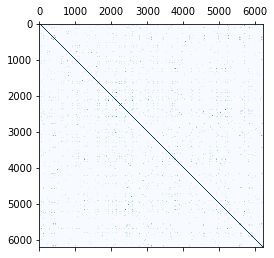

In [237]:
colormap = pylab.cm.Blues
colormap = colormap.reversed()

pylab.matshow(distances, cmap=colormap)
plt.savefig(os.path.join(PLOTS_FOLDER, f"{SIMILARITY_N}.unsorted.png"))
plt.show()

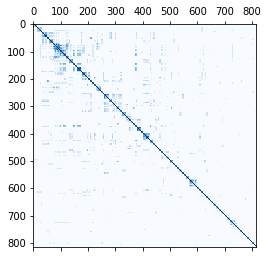

In [238]:
distances_ordered = pairwise_distances(np.asarray(indices_ordered_by_clusters).reshape(-1, 1), metric=ngram_distance_index)

pylab.matshow(distances_ordered, cmap=colormap)
plt.savefig(os.path.join(PLOTS_FOLDER, f"{SIMILARITY_N}.detail.png"))
plt.show()

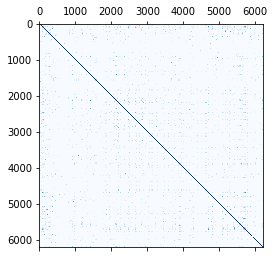

In [239]:
indices_ordered_by_clusters.extend(no_clustering_indices)

distances_ordered = pairwise_distances(np.asarray(indices_ordered_by_clusters).reshape(-1, 1), metric=ngram_distance_index)

pylab.matshow(distances_ordered, cmap=colormap)
plt.savefig(os.path.join(PLOTS_FOLDER, f"{SIMILARITY_N}.sorted.png"))
plt.show()

In [240]:
cluster_sizes = [len(cluster) for cluster in clustered_sentences]

print(f"Min Cluster size: {min(cluster_sizes)}")
print(f"Max Cluster size: {max(cluster_sizes)}")
print(f"Mean Cluster size: {sum(cluster_sizes)/len(cluster_sizes)}")

unclustered_count = len(no_clustering)

print(f"Clustered: {len(different_sentences) - unclustered_count}")
print(f"Unclustered: {unclustered_count}")

Min Cluster size: 5
Max Cluster size: 27
Mean Cluster size: 8.07920792079208
Clustered: 816
Unclustered: 5388


In [241]:
clustered_sentences[2]


['what are the {column} of {table}',
 'what are the {column} of {table} aged {ne}',
 'what are the {column} of {table} ordered alphabetically',
 'what are the {column} of {table} from {ne}',
 'what are the {column} of {table} held {ne}',
 'what are the {column} of {table} without {table}',
 'what are the {column} of {table} {column} {number}']